In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import csv
import os
from dotenv import load_dotenv
import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error

In [2]:
import random
import tensorflow as tf

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Cleaning 

In [3]:
google_data = pd.read_csv('C:/Users/mckay/6300-Data-Project/full_complete_datasets/GOOG_raw_complete_data.csv')

print(google_data.head())

         date  GOOG_close  GOOG_high  GOOG_low  GOOG_open  GOOG_traded_volume  \
0  2014-03-27      558.46     568.00    552.92    568.000               13100   
1  2014-03-28      559.99     566.43    558.67    561.200               41100   
2  2014-03-31      556.97     567.00    556.93    566.890               10800   
3  2014-04-01      567.16     568.45    558.71    558.710                7900   
4  2014-04-02      567.00     604.83    562.19    565.106              146700   

   GOOG_adjClose  GOOG_adjLow  GOOG_adjOpen  GOOG_adj_traded_volume  ...  \
0      27.822745    27.546739     28.298032                  262000  ...   
1      27.898970    27.833207     27.959253                  822000  ...   
2      27.748512    27.746519     28.242731                  216000  ...   
3      28.256183    27.835200     27.835200                  158000  ...   
4      28.248212    28.008575     28.153852                 2934000  ...   

   NVDA_traded_volume  NVDA_adjClose NVDA_adjLow NVDA_ad

In [4]:
# These columns just represents the company's symbol and currency labels and is not useful so we drop it
google_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)

In [5]:
# Check if there are any duplicate rows
duplicates = google_data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Optionally view the duplicate rows
print(google_data[duplicates])



Number of duplicate rows: 42
            date  GOOG_close  GOOG_high   GOOG_low  GOOG_open  \
92    2014-07-31      571.60   583.6499   570.0000     580.60   
93    2014-07-31      571.60   583.6499   570.0000     580.60   
157   2014-10-29      549.33   554.1900   546.9800     550.00   
158   2014-10-29      549.33   554.1900   546.9800     550.00   
159   2014-10-29      549.33   554.1900   546.9800     550.00   
285   2015-04-27      555.37   565.9500   553.2001     563.39   
286   2015-04-27      555.37   565.9500   553.2001     563.39   
287   2015-04-27      555.37   565.9500   553.2001     563.39   
924   2017-10-13      989.68   997.2100   989.0000     992.00   
925   2017-10-13      989.68   997.2100   989.0000     992.00   
1117  2018-07-10     1152.84  1159.5900  1149.5900    1156.98   
1118  2018-07-10     1152.84  1159.5900  1149.5900    1156.98   
1367  2019-07-05     1131.59  1132.8800  1116.1400    1117.80   
1368  2019-07-05     1131.59  1132.8800  1116.1400    1117.80

In [6]:
# Remove duplicate rows
google_data = google_data.drop_duplicates()

# Confirm removal
print(f"Data shape after removing duplicates: {google_data.shape}")


Data shape after removing duplicates: (2796, 159)


## Filling Na Data

In [7]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

pe                                          0.679542
basicMaterialsChangesPercentage           100.000000
communicationServicesChangesPercentage     22.675250
consumerCyclicalChangesPercentage          22.675250
consumerDefensiveChangesPercentage         22.675250
                                             ...    
standardDeviation                           0.071531
tema                                        0.071531
williams                                    0.071531
wma                                         0.071531
NVDA_twitter_social_sentiment              97.818312
Length: 112, dtype: float64


In [8]:
import seaborn as sns

# Function to obtain percentages of missing values 
def percent_missing(google_data):
    nan_percent = 100 * google_data.isnull().sum() / len(google_data)
    nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

    return nan_percent

# Function to plot out missing value percentages by column
def show_percent_missing(google_data):
    nan_percent = percent_missing(google_data)

    plt.figure(figsize=(24, 8))

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

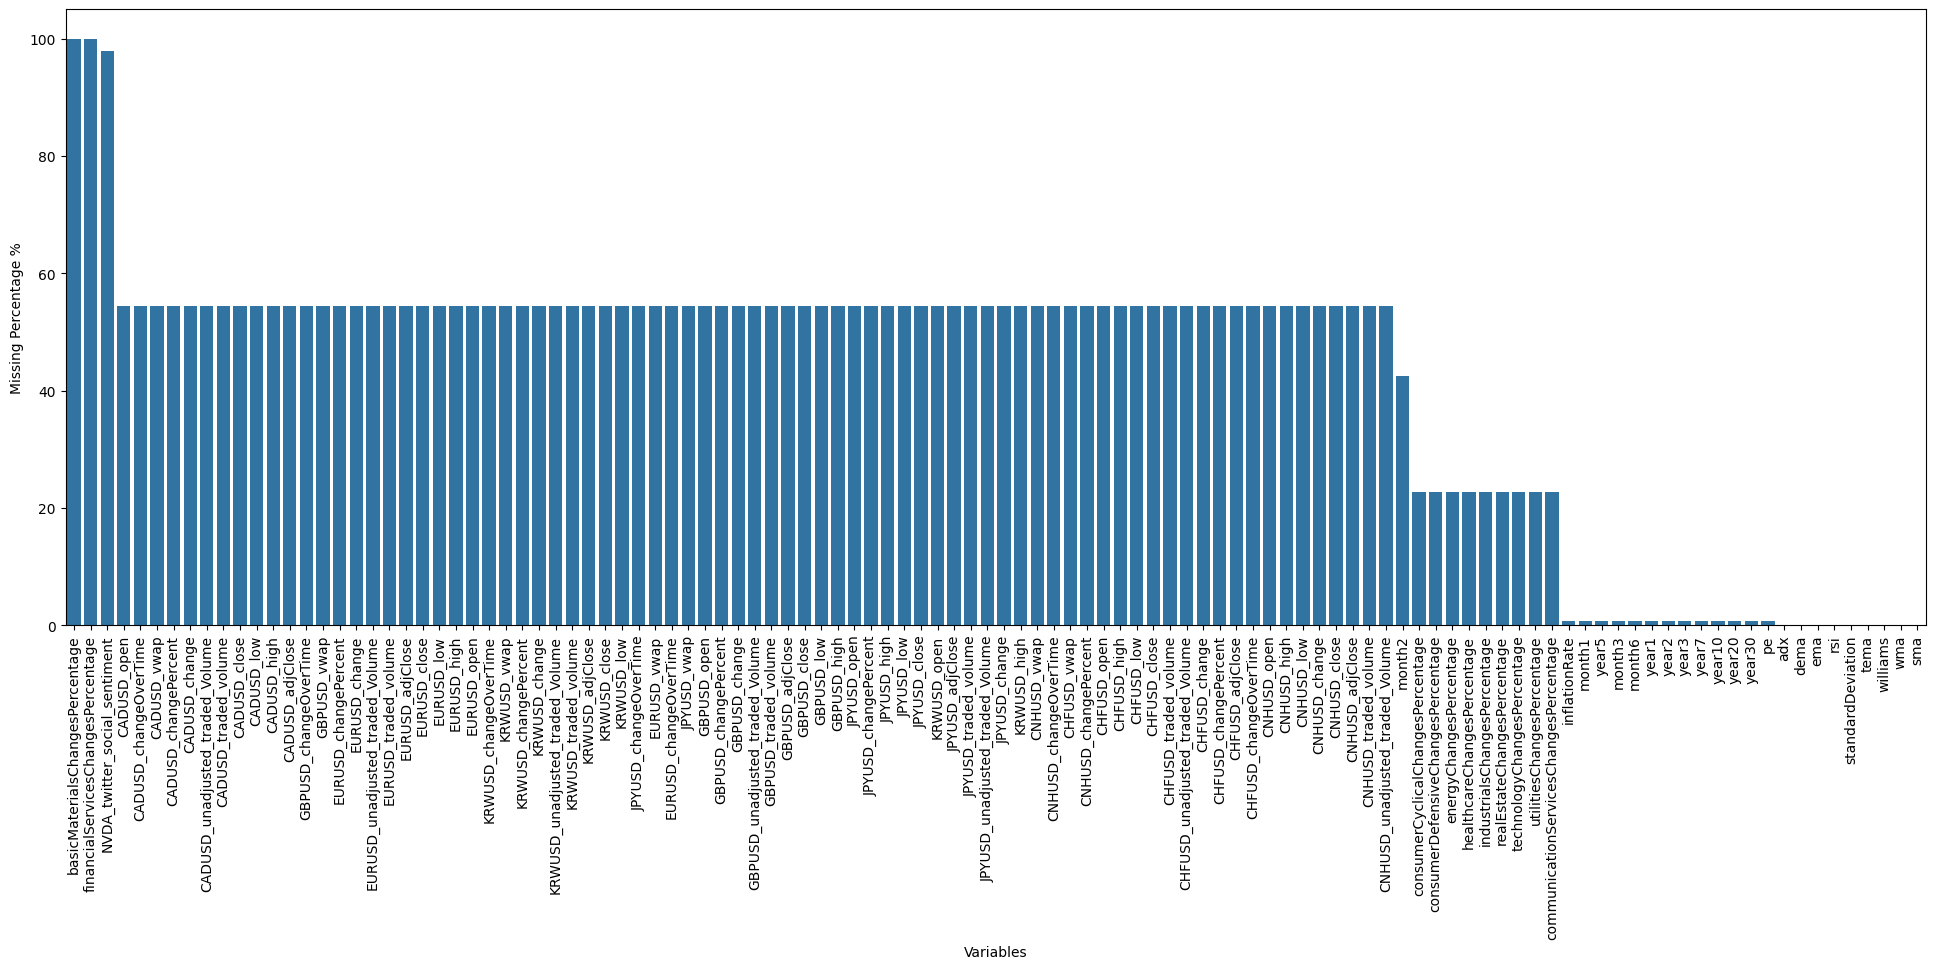

In [9]:
show_percent_missing(google_data)

In [10]:
# Identify columns that are 75% missing
cols_to_remove = [col for col in google_data.columns if google_data[col].isnull().mean() * 100 >= 75]

# Print the removed columns
print("Columns removed due to more than 75% missing values:")
print(cols_to_remove)

# Drop those columns from the data set
google_data = google_data.drop(columns=cols_to_remove)


Columns removed due to more than 75% missing values:
['basicMaterialsChangesPercentage', 'financialServicesChangesPercentage', 'NVDA_twitter_social_sentiment']


In [11]:
#filling the columns with 1% or less missing data with the mode of their columns

#finding all the columns with very little missing data
vsmall_missing_cols = [col for col in google_data.columns if google_data[col].isnull().mean() * 100 <= 1]

# Fill missing values with mode for each identified column
for col in vsmall_missing_cols:
    google_data[col].fillna(google_data[col].mode()[0], inplace=True)

# Print confirmation
print(f"Filled missing values in {len(vsmall_missing_cols)} columns using mode.")


Filled missing values in 69 columns using mode.


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2915749377.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  google_data[col].fillna(google_data[col].mode()[0], inplace=True)
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2915749377.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [12]:
# Identify columns containing either 'changesPercent' or 'ChangesPercentage' (case insensitive)
changes_percent_cols = [col for col in google_data.columns if 'changespercent' in col.lower() or 'changespercentage' in col.lower()]

# Apply rolling mean, then forward-fill and backward-fill as a backup
for col in changes_percent_cols:
    google_data[col] = google_data[col].rolling(window=7, min_periods=1).mean()  # Apply rolling mean
    google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
    google_data[col] = google_data[col].fillna(method='bfill')  # Backward-fill for any remaining NaNs

# Print confirmation
print(f"All missing values in {len(changes_percent_cols)} columns have been filled using rolling mean, forward-fill, and backward-fill.")


All missing values in 9 columns have been filled using rolling mean, forward-fill, and backward-fill.


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\3508482019.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\3508482019.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='bfill')  # Backward-fill for any remaining NaNs


In [13]:
# Identify currency exchange rate columns
currency_cols = [col for col in google_data.columns if 'USD' in col]

# Apply forward-fill, backward-fill, and interpolation
for col in currency_cols:
    google_data[col] = google_data[col].rolling(window=5, min_periods=1).mean()  # Apply rolling mean
    google_data[col] = google_data[col].interpolate(method='linear')  # Interpolation for gradual trends
    google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
    google_data[col] = google_data[col].fillna(method='bfill') 

# Print confirmation
print(f"Filled missing values in {len(currency_cols)} currency exchange rate columns using forward-fill, backward-fill, and interpolation.")


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2531207910.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='ffill')  # Forward-fill to propagate last known value
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2531207910.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  google_data[col] = google_data[col].fillna(method='bfill')


Filled missing values in 77 currency exchange rate columns using forward-fill, backward-fill, and interpolation.


In [14]:
# Compute correlation of all columns with 'SalePrice'
correlations = google_data.corr(numeric_only=True)['month2'].sort_values(ascending=False)

# Show the correlations
print(correlations)


month2               1.000000
month3               0.999167
month1               0.997209
month6               0.992165
year1                0.978418
                       ...   
GOOG_low            -0.890544
GOOG_open           -0.890713
GOOG_close          -0.891128
GOOG_high           -0.891413
standardDeviation         NaN
Name: month2, Length: 151, dtype: float64


In [15]:
from sklearn.linear_model import LinearRegression

train = google_data[google_data['month2'].notna() & google_data['month3'].notna()]
test = google_data[google_data['month2'].isna() & google_data['month3'].notna()]

# Step 3: Train linear regression model
model = LinearRegression()
model.fit(train[['month3']], train['month2'])

# Step 4: Predict missing Month_2 values
predicted_values = model.predict(test[['month3']])

# Step 5: Fill in the missing values
google_data.loc[test.index, 'month2'] = predicted_values

In [16]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

Series([], dtype: float64)


## Cleaning Sentiment Data

In [17]:
google_data['GOOG_stock_news_sentiment'].unique()
google_data['NVDA_stock_news_sentiment'].unique()
google_data['GOOG_press_release_sentiment'].unique()
google_data['NVDA_press_release_sentiment'].unique()

array(['neutral', 'weakly_negative', 'weakly_positive',
       'strongly_positive', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for future dates such as november 16, 2023, as it falls beyond my training data which goes up to october 2023. my responses are based on patterns and information available up to that point and i can only generate predictions or extrapolations from existing knowledge rather than provide insights or data about future events.",
       "i'm sorry, but i cannot provide information or sentiment analysis for future events or hypothetical scenarios beyond my training data, which ends in october 2023.",
       "i'm sorry, but i am unable to provide real-time or future sentiment analysis on specific dates for specific companies.",
       "i'm sorry, but i cannot provide future or speculative information based on historical data.",
       "i'm sorry, but i can’t provide real-time or future information as my training only includes data 

In [18]:
#fixing the sentiment columns that did not get any informaiton from llm
# Replacing values that are not useful as missing 
google_data['GOOG_stock_news_sentiment'][google_data['GOOG_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
google_data['NVDA_stock_news_sentiment'][google_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


# creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

# filling values as missing excluding those in the exclusion list
google_data['GOOG_press_release_sentiment'] = google_data['GOOG_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)
google_data['NVDA_press_release_sentiment'] = google_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(google_data['GOOG_stock_news_sentiment'].unique())
print(google_data['NVDA_stock_news_sentiment'].unique())
print(google_data['GOOG_press_release_sentiment'].unique())
print(google_data['NVDA_press_release_sentiment'].unique())


['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative' nan]
['neutral' 'weakly_negative' 'weakly_positive' 'strongly_positive'
 'strongly_negative' nan]


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2661230784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_data['GOOG_stock_news_sentiment'][google_data['GOOG_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2661230784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_data['NVDA_stock_news_sentiment'][google_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


In [19]:
# #converting date to time series
google_data['date'] = pd.to_datetime(google_data['date'])
google_data.set_index('date', inplace=True)

# Add 'year' and 'month' columns to use for averages
google_data['year'] = google_data.index.year
google_data['month'] = google_data.index.month

#filling with mode for each month, and the months where there is no mode, fill sentiment with neutral

def fill_mode_or_neutral(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode.iloc[0])
    else:
        return series.fillna('neutral')

google_data['GOOG_press_release_sentiment'] = (
    google_data.groupby(['year', 'month'])['GOOG_press_release_sentiment']
    .transform(fill_mode_or_neutral)
)

google_data['NVDA_press_release_sentiment'] = (
    google_data.groupby(['year', 'month'])['NVDA_press_release_sentiment']
    .transform(fill_mode_or_neutral)
)

C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\770520464.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  google_data['year'] = google_data.index.year
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\770520464.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  google_data['month'] = google_data.index.month


In [20]:
# Calculate percentage of missing values for each column
missing_percentages = (google_data.isnull().sum() / len(google_data)) * 100

# Display only columns with missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Show the results
print(missing_percentages)

Series([], dtype: float64)


In [185]:
google_data.describe()

,GOOG_close,GOOG_high,GOOG_low,GOOG_open,GOOG_traded_volume,GOOG_adjClose,GOOG_adjLow,GOOG_adjOpen,GOOG_adj_traded_volume,GOOG_divCash,...,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,year,month
count,2796.000000,2796.000000,2796.000000,2796.000000,2.796000e+03,2796.000000,2796.000000,2796.000000,2.796000e+03,2796.000000,...,2796.000000,2.796000e+03,2796.000000,2796.000000,2796.000000,2.796000e+03,2796.000000,2796.000000,2796.000000,2796.000000
mean,981.090590,990.557595,971.078571,980.690113,6.735775e+06,80.121451,79.286450,80.080264,3.098204e+07,0.000215,...,227.196935,4.214457e+07,20.925356,20.504710,20.937968,5.787125e+08,0.001586,1.004292,2019.177754,6.564378
std,763.480462,771.476023,755.269076,763.339244,1.030117e+07,46.776164,46.280861,46.762252,1.571544e+07,0.006549,...,203.241184,1.884033e+08,34.121570,33.430107,34.188719,6.979665e+09,0.014197,0.179393,3.166611,3.431695
min,83.490000,86.550000,83.450000,85.510000,7.900000e+03,24.539077,24.290473,24.643700,1.580000e+05,0.000000,...,16.930000,1.141128e+06,0.401226,0.400868,0.404692,4.564512e+07,0.000000,1.000000,2014.000000,1.000000
25%,520.377500,526.232500,516.267500,522.682500,1.277025e+06,39.415223,39.137225,39.345972,2.121522e+07,0.000000,...,93.427500,8.097073e+06,2.302232,2.271425,2.307159,2.884756e+08,0.000000,1.000000,2016.000000,4.000000
50%,806.810000,810.580000,802.315000,807.040000,1.707259e+06,60.651949,60.085466,60.756323,2.720289e+07,0.000000,...,175.760000,1.349824e+07,6.105910,6.009873,6.097741,3.975452e+08,0.000000,1.000000,2019.000000,7.000000
75%,1238.812500,1247.602500,1227.922500,1237.870000,4.393596e+06,119.599042,118.590177,119.636407,3.599548e+07,0.000000,...,272.740000,4.038879e+07,20.605588,20.189427,20.497049,5.409924e+08,0.000000,1.000000,2022.000000,10.000000
max,3014.180000,3042.000000,2997.750000,3037.270000,9.779857e+07,207.710000,204.260000,204.500000,2.232989e+08,0.200000,...,1240.480000,9.232320e+09,149.430000,147.820100,153.030000,3.692928e+11,0.160000,10.000000,2025.000000,12.000000


# Modelling

In [21]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [22]:
#reading in the actual stock prices for the dates we are forecasting 
google_real = pd.read_csv('C:/Users/mckay/6300-Data-Project/march_prices/GOOG_march_prices.csv', parse_dates=['date'])

In [23]:
# Clean up and keep only the necessary columns
google_real_sc = google_real[['date', 'GOOG_adjClose']]  
google_real_sc = google_real.rename(columns={'GOOG_adjClose': 'Actual Price'})

# Reset index (optional)
google_real_sc.reset_index(drop=True, inplace=True)

In [24]:
google_real['date'] = pd.to_datetime(google_real['date'], dayfirst=True)

close_real = google_real['GOOG_adjClose'].values

In [190]:
# #Create lagged features for GOOG
# def create_lagged_features_google(data, target_col, external_features, max_lag=60):
#     df = data.copy()

#     # Lag target
#     for lag in range(1, 8):
#         df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

#     for feature in external_features:
#         if feature == 'inflationRate':
#             for lag in range(1, max_lag + 1):
#                 df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
#         elif feature in ['Gold_price', 'Silver_price']:
#             for lag in range(1, 8):
#                 df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
#         elif feature in ['GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']:
#             for lag in range(1, 6 if 'GOOG' in feature else 8):
#                 df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

#     return df

# # --- Step 2: Apply lagging and sentiment encoding ---
# external_features = ['inflationRate', 'Gold_price', 'Silver_price',
#                      'GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']

# sentiment_map = {
#     'very_negative': -2,
#     'weakly_negative': -1,
#     'neutral': 0,
#     'weakly_positive': 1,
#     'very_positive': 2
# }

# df_lagged = create_lagged_features_google(google_data, target_col='GOOG_adjClose', external_features=external_features)

# # Apply sentiment map
# for col in [col for col in df_lagged.columns if 'sentiment' in col]:
#     df_lagged[col] = df_lagged[col].map(sentiment_map)

# # Drop only rows with NaNs in the lag features
# lag_features = [col for col in df_lagged.columns if 'lag_' in col]
# df_lagged.dropna(subset=lag_features, inplace=True)

# google_data.reset_index(inplace=True)
# df_lagged['date'] = google_data['date'].iloc[-len(df_lagged):].values
# df_lagged['date'] = pd.to_datetime(df_lagged['date']) 

# # --- Step 3: Prepare features and target ---
# X = df_lagged[lag_features]
# y = df_lagged['GOOG_adjClose']

# # Scale
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# scaler_y = StandardScaler()
# y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()  # flatten after scaling


In [204]:
# --- Step 1: Create lagged features for GOOG with enhancements ---
def create_lagged_features_google(data, target_col, external_features, max_lag=60):
    df = data.copy()

    # lag target feature (stock price) from 1 to 7 days
    for lag in range(1, 8):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # adding in rolling stats like mean and sd to try and capture more of the volatility
    for window in [5]:
        df[f'{target_col}_roll_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'{target_col}_roll_std_{window}'] = df[target_col].rolling(window=window).std()

    # Selectively lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Silver_price':
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in [5]:
                df[f'{feature}_roll_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_roll_std_{window}'] = df[feature].rolling(window=window).std()

        elif feature == 'GOOG_stock_news_sentiment':
            for lag in range(1, 6):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            for lag in range(1, 8):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    # Momentum and rate of change
    df[f'{target_col}_momentum_5'] = df[target_col] - df[target_col].shift(5)
    df[f'{target_col}_roc_5'] = (df[target_col] - df[target_col].shift(5)) / df[target_col].shift(5)

    df.dropna(inplace=True)
    return df

# --- Create lagged features ---
df_lagged = create_lagged_features_google(
    google_data,
    target_col='GOOG_adjClose',
    external_features=['inflationRate', 'Gold_price', 'Silver_price', 'GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']
)

# --- Encode sentiment ---
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 1
}

sentiment_cols = [col for col in df_lagged.columns if 'sentiment' in col]
for col in sentiment_cols:
    df_lagged[col] = df_lagged[col].map(sentiment_map)

# --- Extra features ---
df_lagged['GOOG_sentiment_avg_3'] = df_lagged[[
    'GOOG_stock_news_sentiment_lag_1',
    'GOOG_stock_news_sentiment_lag_2',
    'GOOG_stock_news_sentiment_lag_3'
]].mean(axis=1)

df_lagged['price_sentiment_interaction'] = df_lagged['GOOG_adjClose'].shift(1) * df_lagged['GOOG_stock_news_sentiment_lag_1']

# --- Drop NaNs ---
lag_features = [col for col in df_lagged.columns if 'lag_' in col or 'rolling' in col or 'momentum' in col or 'roc' in col or 'sentiment_avg' in col or 'interaction' in col]
df_lagged.dropna(subset=lag_features, inplace=True)

# Prepare static feature DataFrame
static_features = ['technologyChangesPercentage', 'NVDA_adjClose', 'pe', 'Silver_price']

# --- Final preparation ---
X = df_lagged[lag_features + static_features]
y = df_lagged['GOOG_adjClose']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2790058904.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2790058904.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2790058904.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

#adding in static features to try and improve model performance
# static_features = ['technologyChangesPercentage',
#     'communicationServicesChangesPercentage',
#     'Copper_price',
#     'EURUSD_close',
#     'JPYUSD_close',
#     'pe',
#     'ema',
#     'GOOG_press_release_sentiment',
#     'NVDA_adjClose']

In [152]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_scaled, y_scaled)
importances = rf.feature_importances_

# Show top features
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feat_imp.head(10))


KeyboardInterrupt: 

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming importances and feature names are already available
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
feat_imp_sorted.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


NameError: name 'rf' is not defined

## Model 1: Lasso

In [194]:
# #lasso training
# tscv = TimeSeriesSplit(n_splits=5)
# lasso_cv = LassoCV(alphas=np.logspace(-4, 3, 100), cv=tscv, max_iter=10000)
# lasso_cv.fit(X_scaled, y_scaled)
# y_pred_scaled = lasso_cv.predict(X_scaled)

# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# print(f"Best alpha: {lasso_cv.alpha_}")

In [205]:
# Make sure 'date' is datetime
df_lagged['date'] = pd.to_datetime(df_lagged['date'])

# Extract target and features
df_lagged['date'] = pd.to_datetime(df_lagged['date'])
target = 'GOOG_adjClose'
lag_features = [col for col in df_lagged.columns if 'lag' in col]

X = df_lagged[lag_features]
y = df_lagged[target]
dates = df_lagged['date']

# Scale features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()

X_scaled_df = pd.DataFrame(X_scaled, columns=lag_features)
#X_scaled_df['date'] = dates
X_scaled_df['date'] = dates.reset_index(drop=True)

# Step 1: Tune Lasso using KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 3, 180),
    cv=kfold,
    random_state=1,
    max_iter=25000,
    n_jobs=-1
)
lasso_cv.fit(X_scaled_df.drop(columns='date'), y)
best_alpha = lasso_cv.alpha_
print(f"Best alpha from CV: {best_alpha}")

Best alpha from CV: 0.02028909005625913


In [206]:
tscv = TimeSeriesSplit(n_splits=10)
final_lasso = Lasso(alpha=best_alpha, max_iter=25000)

all_dates = []
lasso_actuals = []
lasso_preds = []

for train_idx, val_idx in tscv.split(X_scaled_df):
    x_train = X_scaled_df.iloc[train_idx].drop(columns='date')
    x_val = X_scaled_df.iloc[val_idx].drop(columns='date')
    y_train = y_scaled[train_idx]
    y_val = y_scaled[val_idx]

    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_val)

    all_dates.extend(X_scaled_df.iloc[val_idx]['date'])
    lasso_actuals.extend(scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten())
    lasso_preds.extend(scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten())

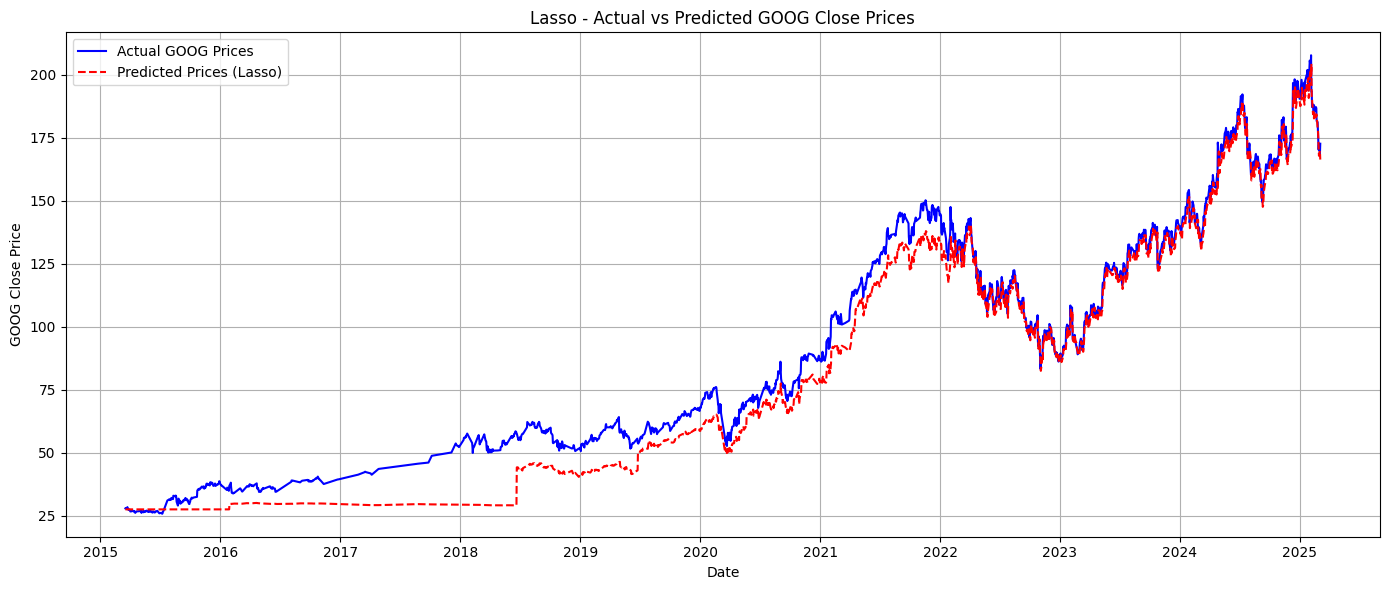

In [207]:
plt.figure(figsize=(14, 6))
plt.plot(all_dates, lasso_actuals, label='Actual GOOG Prices', color='blue')
plt.plot(all_dates, lasso_preds, label='Predicted Prices (Lasso)', color='red', linestyle='--')
plt.title('Lasso - Actual vs Predicted GOOG Close Prices')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [208]:
last_known = df_lagged.iloc[-1:].copy()
lasso_future_preds = []

# Generate the next 15 business days
last_date = pd.to_datetime(df_lagged['date'].iloc[-1])
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=15)

for i in range(len(future_dates)):
    # --- Extract current input and scale ---
    X_input = last_known[lag_features].iloc[-1:].values
    X_scaled = scaler_X.transform(X_input)

    # --- Predict next value ---
    next_scaled_pred = final_lasso.predict(X_scaled)[0]
    next_pred = max(0, scaler_y.inverse_transform([[next_scaled_pred]])[0, 0])  # unscale
    lasso_future_preds.append(next_pred)

    # --- Prepare next row ---
    next_row = last_known.iloc[-1:].copy()

    # --- SHIFT TARGET LAGS ---
    for lag in range(7, 1, -1):
        next_row[f'{target}_lag_{lag}'] = last_known.iloc[-1][f'{target}_lag_{lag - 1}']
    next_row[f'{target}_lag_1'] = next_pred

    # --- SHIFT EXOGENOUS FEATURES ---
    for feature in ['inflationRate', 'Gold_price', 'Silver_price', 
                    'GOOG_stock_news_sentiment', 'NVDA_stock_news_sentiment']:
        max_lag = 60 if feature == 'inflationRate' else (
            7 if feature in ['Gold_price', 'Silver_price', 'NVDA_stock_news_sentiment'] else 5)

        for lag in range(max_lag, 1, -1):
            prev_col = f'{feature}_lag_{lag - 1}'
            curr_col = f'{feature}_lag_{lag}'
            if prev_col in last_known.columns:
                next_row[curr_col] = last_known.iloc[-1][prev_col]

        if f'{feature}_lag_1' in last_known.columns:
            next_row[f'{feature}_lag_1'] = last_known.iloc[-1][f'{feature}_lag_1']
            # Optional: add noise to simulate variation
            # next_row[f'{feature}_lag_1'] *= np.random.normal(1, 0.002)

    # --- Append new row ---
    last_known = pd.concat([last_known, next_row.tail(1)], ignore_index=True)

    # --- Debug output ---
    print(f"Day {i+1} lags:", [next_row[f'{target}_lag_{j}'] for j in range(1, 8)])


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 1 lags: [2795    166.321525
Name: GOOG_adjClose_lag_1, dtype: float64, 2795    168.66
Name: GOOG_adjClose_lag_2, dtype: float64, 2795    172.22
Name: GOOG_adjClose_lag_3, dtype: float64, 2795    170.21
Name: GOOG_adjClose_lag_4, dtype: float64, 2795    174.7
Name: GOOG_adjClose_lag_5, dtype: float64, 2795    177.37
Name: GOOG_adjClose_lag_6, dtype: float64, 2795    181.19
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 2 lags: [1    164.046706
Name: GOOG_adjClose_lag_1, dtype: float64, 1    166.321525
Name: GOOG_adjClose_lag_2, dtype: float64, 1    168.66
Name: GOOG_adjClose_lag_3, dtype: float64, 1    172.22
Name: GOOG_adjClose_lag_4, dtype: float64, 1    170.21
Name: GOOG_adjClose_lag_5, dtype: float64, 1    174.7
Name: GOOG_adjClose_lag_6, dtype: float64, 1    177.37
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


Day 3 lags: [2    161.833802
Name: GOOG_adjClose_lag_1, dtype: float64, 2    164.046706
Name: GOOG_adjClose_lag_2, dtype: float64, 2    166.321525
Name: GOOG_adjClose_lag_3, dtype: float64, 2    168.66
Name: GOOG_adjClose_lag_4, dtype: float64, 2    172.22
Name: GOOG_adjClose_lag_5, dtype: float64, 2    170.21
Name: GOOG_adjClose_lag_6, dtype: float64, 2    174.7
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


Day 4 lags: [3    159.681082
Name: GOOG_adjClose_lag_1, dtype: float64, 3    161.833802
Name: GOOG_adjClose_lag_2, dtype: float64, 3    164.046706
Name: GOOG_adjClose_lag_3, dtype: float64, 3    166.321525
Name: GOOG_adjClose_lag_4, dtype: float64, 3    168.66
Name: GOOG_adjClose_lag_5, dtype: float64, 3    172.22
Name: GOOG_adjClose_lag_6, dtype: float64, 3    170.21
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 5 lags: [4    157.586801
Name: GOOG_adjClose_lag_1, dtype: float64, 4    159.681082
Name: GOOG_adjClose_lag_2, dtype: float64, 4    161.833802
Name: GOOG_adjClose_lag_3, dtype: float64, 4    164.046706
Name: GOOG_adjClose_lag_4, dtype: float64, 4    166.321525
Name: GOOG_adjClose_lag_5, dtype: float64, 4    168.66
Name: GOOG_adjClose_lag_6, dtype: float64, 4    172.22
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 6 lags: [5    155.549823
Name: GOOG_adjClose_lag_1, dtype: float64, 5    157.586801
Name: GOOG_adjClose_lag_2, dtype: float64, 5    159.681082
Name: GOOG_adjClose_lag_3, dtype: float64, 5    161.833802
Name: GOOG_adjClose_lag_4, dtype: float64, 5    164.046706
Name: GOOG_adjClose_lag_5, dtype: float64, 5    166.321525
Name: GOOG_adjClose_lag_6, dtype: float64, 5    168.66
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 7 lags: [6    153.568189
Name: GOOG_adjClose_lag_1, dtype: float64, 6    155.549823
Name: GOOG_adjClose_lag_2, dtype: float64, 6    157.586801
Name: GOOG_adjClose_lag_3, dtype: float64, 6    159.681082
Name: GOOG_adjClose_lag_4, dtype: float64, 6    161.833802
Name: GOOG_adjClose_lag_5, dtype: float64, 6    164.046706
Name: GOOG_adjClose_lag_6, dtype: float64, 6    166.321525
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 8 lags: [7    151.640476
Name: GOOG_adjClose_lag_1, dtype: float64, 7    153.568189
Name: GOOG_adjClose_lag_2, dtype: float64, 7    155.549823
Name: GOOG_adjClose_lag_3, dtype: float64, 7    157.586801
Name: GOOG_adjClose_lag_4, dtype: float64, 7    159.681082
Name: GOOG_adjClose_lag_5, dtype: float64, 7    161.833802
Name: GOOG_adjClose_lag_6, dtype: float64, 7    164.046706
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 9 lags: [8    149.765217
Name: GOOG_adjClose_lag_1, dtype: float64, 8    151.640476
Name: GOOG_adjClose_lag_2, dtype: float64, 8    153.568189
Name: GOOG_adjClose_lag_3, dtype: float64, 8    155.549823
Name: GOOG_adjClose_lag_4, dtype: float64, 8    157.586801
Name: GOOG_adjClose_lag_5, dtype: float64, 8    159.681082
Name: GOOG_adjClose_lag_6, dtype: float64, 8    161.833802
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 10 lags: [9    147.940984
Name: GOOG_adjClose_lag_1, dtype: float64, 9    149.765217
Name: GOOG_adjClose_lag_2, dtype: float64, 9    151.640476
Name: GOOG_adjClose_lag_3, dtype: float64, 9    153.568189
Name: GOOG_adjClose_lag_4, dtype: float64, 9    155.549823
Name: GOOG_adjClose_lag_5, dtype: float64, 9    157.586801
Name: GOOG_adjClose_lag_6, dtype: float64, 9    159.681082
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 11 lags: [10    146.166388
Name: GOOG_adjClose_lag_1, dtype: float64, 10    147.940984
Name: GOOG_adjClose_lag_2, dtype: float64, 10    149.765217
Name: GOOG_adjClose_lag_3, dtype: float64, 10    151.640476
Name: GOOG_adjClose_lag_4, dtype: float64, 10    153.568189
Name: GOOG_adjClose_lag_5, dtype: float64, 10    155.549823
Name: GOOG_adjClose_lag_6, dtype: float64, 10    157.586801
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 12 lags: [11    144.44008
Name: GOOG_adjClose_lag_1, dtype: float64, 11    146.166388
Name: GOOG_adjClose_lag_2, dtype: float64, 11    147.940984
Name: GOOG_adjClose_lag_3, dtype: float64, 11    149.765217
Name: GOOG_adjClose_lag_4, dtype: float64, 11    151.640476
Name: GOOG_adjClose_lag_5, dtype: float64, 11    153.568189
Name: GOOG_adjClose_lag_6, dtype: float64, 11    155.549823
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 13 lags: [12    142.760746
Name: GOOG_adjClose_lag_1, dtype: float64, 12    144.44008
Name: GOOG_adjClose_lag_2, dtype: float64, 12    146.166388
Name: GOOG_adjClose_lag_3, dtype: float64, 12    147.940984
Name: GOOG_adjClose_lag_4, dtype: float64, 12    149.765217
Name: GOOG_adjClose_lag_5, dtype: float64, 12    151.640476
Name: GOOG_adjClose_lag_6, dtype: float64, 12    153.568189
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\skl

Day 14 lags: [13    141.127106
Name: GOOG_adjClose_lag_1, dtype: float64, 13    142.760746
Name: GOOG_adjClose_lag_2, dtype: float64, 13    144.44008
Name: GOOG_adjClose_lag_3, dtype: float64, 13    146.166388
Name: GOOG_adjClose_lag_4, dtype: float64, 13    147.940984
Name: GOOG_adjClose_lag_5, dtype: float64, 13    149.765217
Name: GOOG_adjClose_lag_6, dtype: float64, 13    151.640476
Name: GOOG_adjClose_lag_7, dtype: float64]
Day 15 lags: [14    139.537918
Name: GOOG_adjClose_lag_1, dtype: float64, 14    141.127106
Name: GOOG_adjClose_lag_2, dtype: float64, 14    142.760746
Name: GOOG_adjClose_lag_3, dtype: float64, 14    144.44008
Name: GOOG_adjClose_lag_4, dtype: float64, 14    146.166388
Name: GOOG_adjClose_lag_5, dtype: float64, 14    147.940984
Name: GOOG_adjClose_lag_6, dtype: float64, 14    149.765217
Name: GOOG_adjClose_lag_7, dtype: float64]


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


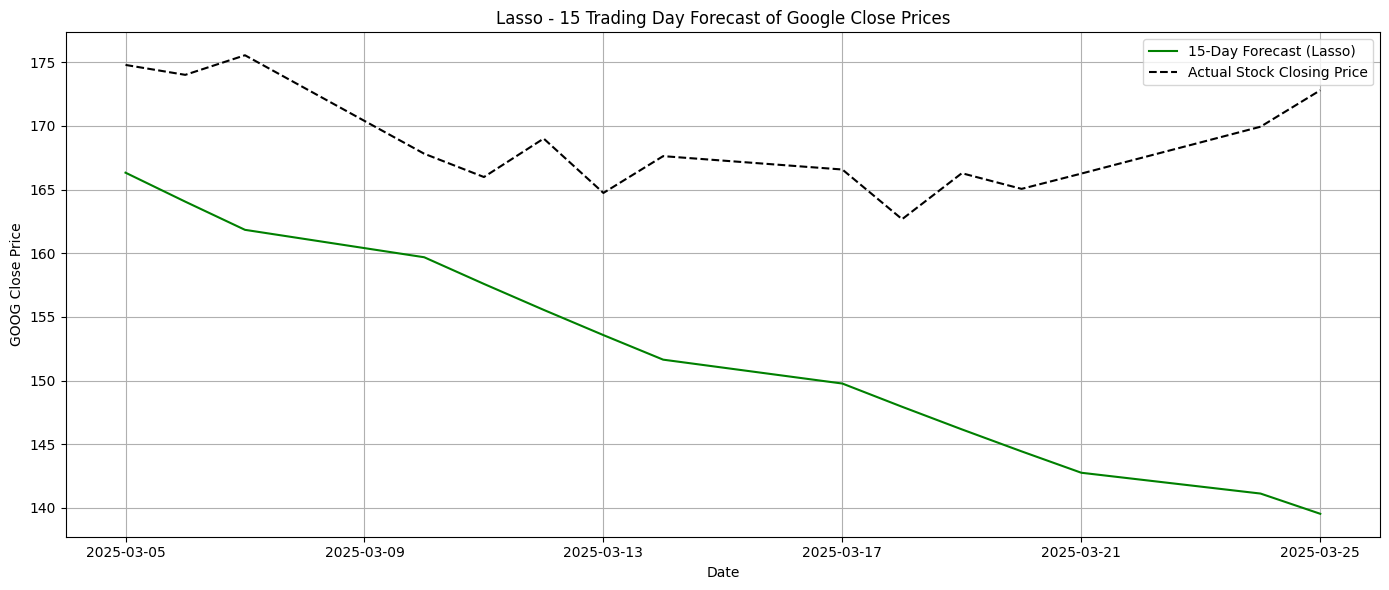

In [209]:
# Final plot: historical + forecast
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lasso_future_preds, label='15-Day Forecast (Lasso)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('Lasso - 15 Trading Day Forecast of Google Close Prices')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [210]:
#finding the Pearson and Spearman Cooefficents to see how well the model is forecasting
lasso_pearson_corr, _ = pearsonr(lasso_future_preds, close_real)
lasso_spearman_corr, _= spearmanr(lasso_future_preds, close_real)
lasso_mse = mean_squared_error(lasso_future_preds, close_real)

print(f"Lasso Pearson Correlation: {lasso_pearson_corr:.4f}")
print(f"Lasso Spearman Correlation: {lasso_spearman_corr:.4f}")
print(f"Lasso MSE: {lasso_mse:.4f}")

Lasso Pearson Correlation: 0.4641
Lasso Spearman Correlation: 0.3821
Lasso MSE: 324.7775


## Model 2: LSTM

In [211]:
from sklearn.preprocessing import MinMaxScaler

# lag features (and optionally external features)
lag_features = [col for col in df_lagged.columns if 'lag' in col]

features = lag_features + static_features

X = df_lagged[features].values
y = df_lagged['GOOG_adjClose'].values

# Scale features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))


# Reshape into (samples, timesteps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # 1 timestep

In [212]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


lstm_model = Sequential()
lstm_model.add(LSTM(units=60, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Add early stopping
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train with early stopping
lstm_model.fit(
    X_reshaped, y_scaled,
    epochs=50,               
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0399
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8033e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2624e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9456e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3606e-04
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1238e-04
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0218e-04
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9529e-04
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.9249e-04
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8925e-04
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8165e-04
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7270e-04
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


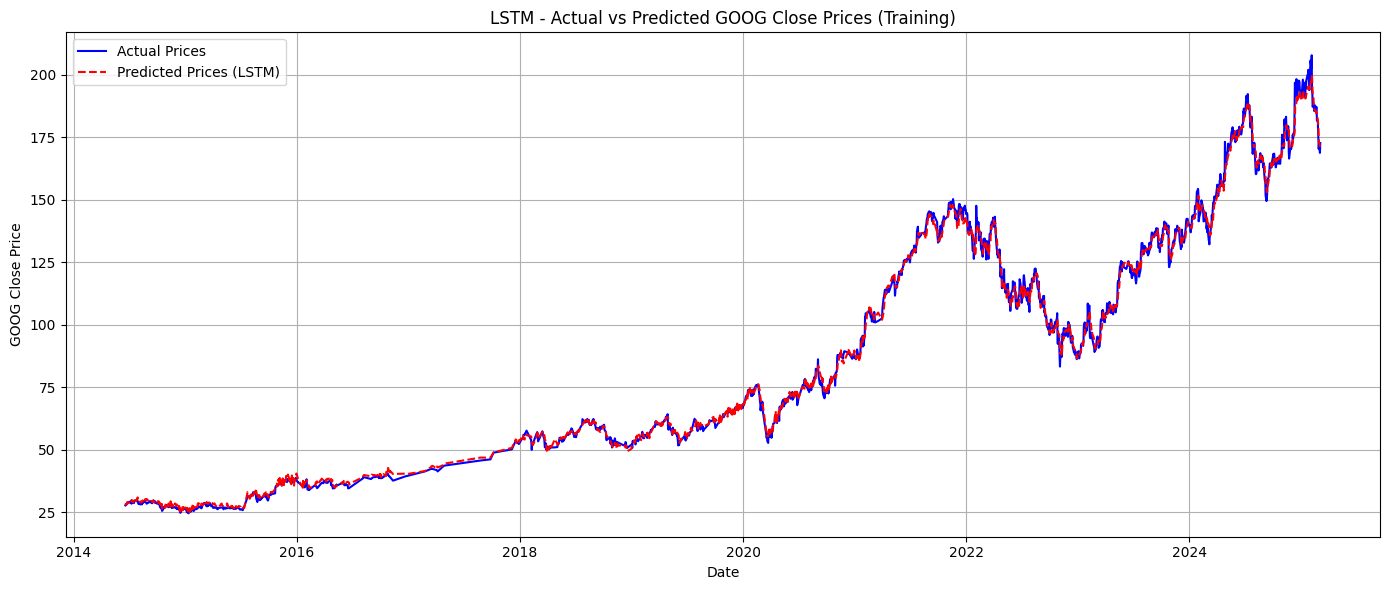

In [213]:
# Predict on training data
train_preds_scaled = lstm_model.predict(X_reshaped)
train_preds = scaler_y.inverse_transform(train_preds_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1, 1)).ravel()
dates = pd.to_datetime(df_lagged['date'])  # assumes Date is present

# Plot
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Prices', color='blue')
plt.plot(dates, train_preds, label='Predicted Prices (LSTM)', color='red', linestyle='--')
plt.title('LSTM - Actual vs Predicted GOOG Close Prices (Training)')
plt.xlabel('Date')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [162]:
print(X_reshaped.shape)  # should be (samples, 1, features)
print(last_input.shape)


(1846, 1, 94)
(1, 102)


In [214]:
last_input = X_scaled[:, :X_reshaped.shape[2]][-1:].copy()  # Last row of training input
lstm_future_preds = []

for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_reshaped.shape[2]))
    next_scaled_pred = lstm_model.predict(input_seq)[0][0]
    next_pred = scaler_y.inverse_transform([[next_scaled_pred]])[0][0]
    lstm_future_preds.append(next_pred)

    # Shift and insert new prediction into first lag
    new_lag_input = np.roll(last_input, shift=1)
    #new_lag_input[0, 0] = next_scaled_pred  # assuming target lag is at index 0
    #gives more realistic price movement
    new_lag_input[0, 0] = 0.7 * last_input[0, 1] + 0.3 * next_scaled_pred
    last_input = new_lag_input




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


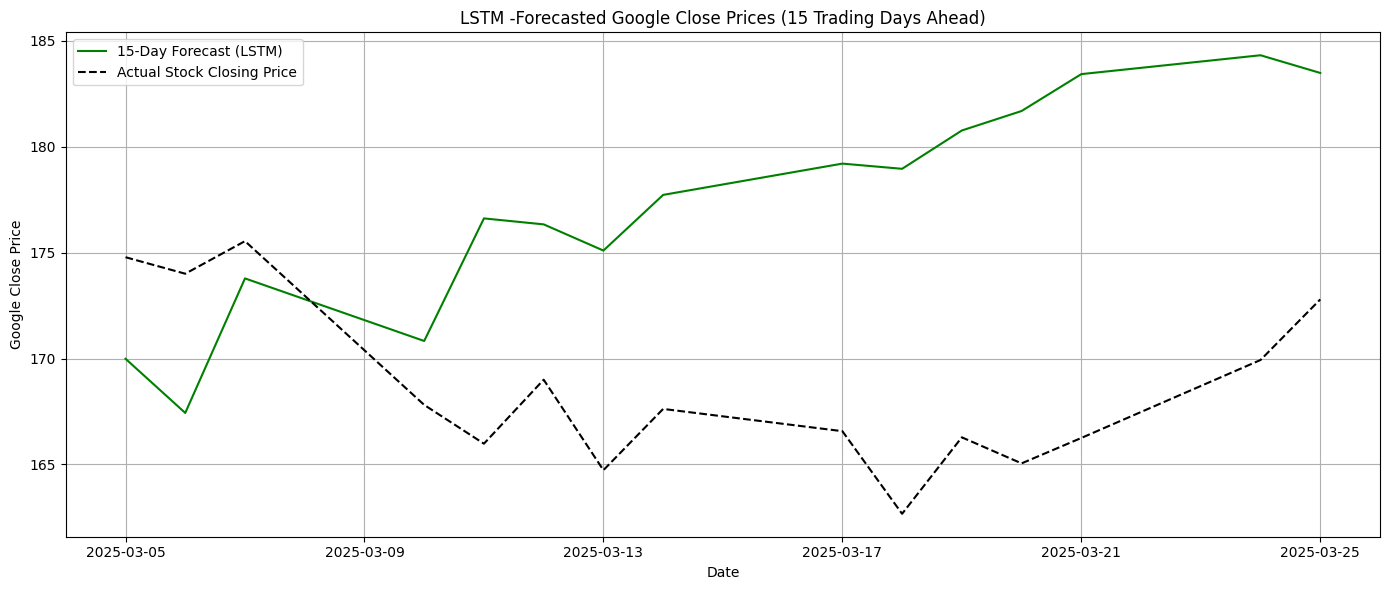

In [215]:
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lstm_future_preds, label='15-Day Forecast (LSTM)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('LSTM -Forecasted Google Close Prices (15 Trading Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Google Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [216]:
lstm_pearson_corr, _ = pearsonr(lstm_future_preds, close_real)
lstm_spearman_corr, _= spearmanr(lstm_future_preds, close_real)
lstm_mse = mean_squared_error(lstm_future_preds, close_real)

print(f"LSTM Pearson Correlation: {lstm_pearson_corr:.4f}")
print(f"LSTM Spearman Correlation: {lstm_spearman_corr:.4f}")
print(f"LSTM MSE: {lstm_mse: .4f}")

LSTM Pearson Correlation: -0.4336
LSTM Spearman Correlation: -0.3250
LSTM MSE:  132.1420


## Model 3: Bi-LSTM

In [39]:
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [217]:
from sklearn.model_selection import train_test_split

y_scaled = y_scaled.ravel()

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_scaled, test_size=0.2, shuffle=False)



In [218]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=50), input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
bilstm_model.add(Dense(1))
bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train
bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0342 - val_loss: 0.0018
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8095e-04 - val_loss: 0.0015
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.8834e-04 - val_loss: 0.0022
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8408e-04 - val_loss: 0.0029
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5668e-04 - val_loss: 0.0033
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6023e-04 - val_loss: 0.0031
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6522e-04 - val_loss: 0.0024
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5290e-04 - val_loss: 0.0019
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3402e-04 - val_loss: 0.0016
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2536e-04 - val_loss: 0.0014
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━

In [219]:
y_train_pred = bilstm_model.predict(X_train)
y_val_pred = bilstm_model.predict(X_val)

# Inverse transform to original scale
# y_train_actual = scaler_y.inverse_transform(y_train)
# y_val_actual = scaler_y.inverse_transform(y_val)
# y_train_pred = scaler_y.inverse_transform(y_train_pred)
# y_val_pred = scaler_y.inverse_transform(y_val_pred)

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_val_actual = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_val_pred = scaler_y.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()




53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


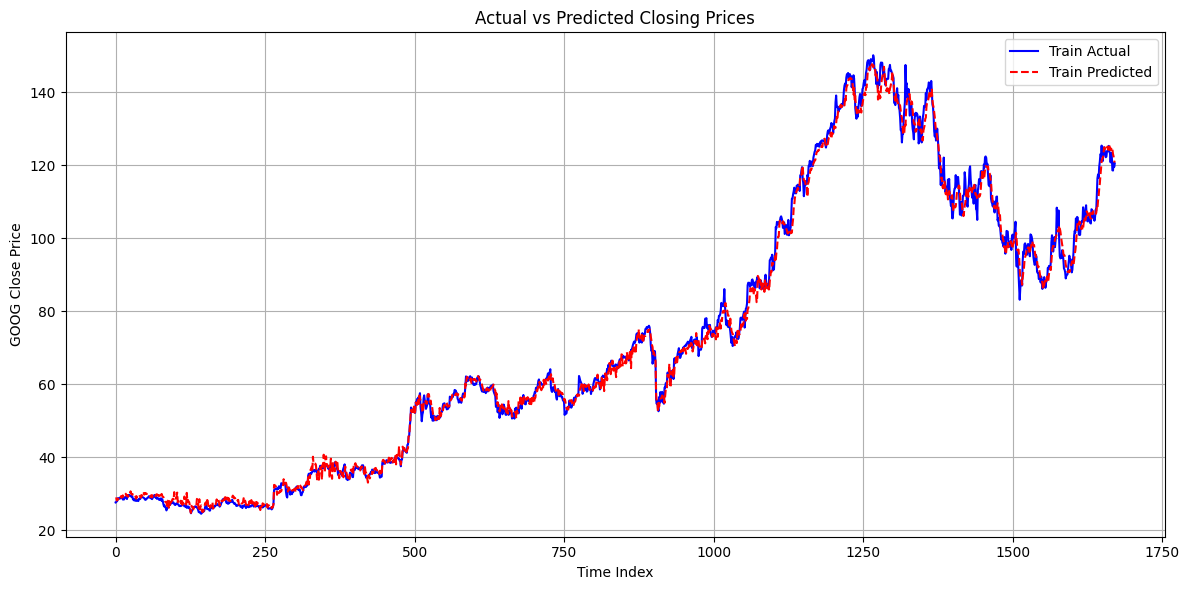

In [220]:
plt.figure(figsize=(12, 6))

# Plot training set
plt.plot(y_train_actual, label='Train Actual', color='blue')
plt.plot(y_train_pred, label='Train Predicted', linestyle='--', color='red')

# Plot validation set (offset to start after training set)
val_start_idx = len(y_train_actual)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time Index')
plt.ylabel('GOOG Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [221]:
last_input = X_scaled[-1:].copy()
bilstm_future_preds_scaled = []

for _ in range(len(future_dates)):
    input_seq = last_input.reshape((1, 1, X_scaled.shape[1]))  # shape = (1, 1, features)
    next_scaled_pred = bilstm_model.predict(input_seq)[0][0]
    bilstm_future_preds_scaled.append(next_scaled_pred)

    # Shift and update lags (simulate next input)
    new_lag_input = np.roll(last_input, shift=1)
    new_lag_input[0, 0] = next_scaled_pred  # assume target is at col 0
    last_input = new_lag_input

#unscaling the y values
bilstm_future_preds = scaler_y.inverse_transform(np.array(bilstm_future_preds_scaled).reshape(-1, 1)).ravel()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


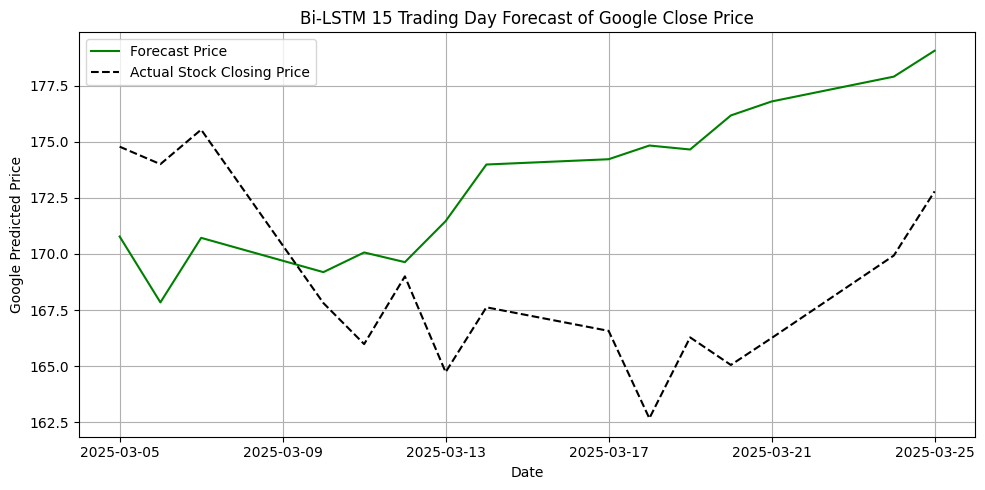

In [222]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(future_dates, bilstm_future_preds, label='Forecast Price', color="green")
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label = 'Actual Stock Closing Price', color = 'black', linestyle = '--')
plt.title('Bi-LSTM 15 Trading Day Forecast of Google Close Price')
plt.xlabel('Date')
plt.ylabel('Google Predicted Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#checking the pearson and spearman correlations 

bistm_pearson_corr, _ = pearsonr(bilstm_future_preds, close_real)
bilstm_spearman_corr, _= spearmanr(bilstm_future_preds, close_real)
bilstm_mse = mean_squared_error(bilstm_future_preds, close_real)


print(f"BiLSTM Pearson Correlation: {bistm_pearson_corr:.4f}")
print(f"BiLSTM Spearman Correlation: {bilstm_spearman_corr:.4f}")
print(f"BiLSTM MSE:                  {bilstm_mse:.4f}")

BiLSTM Pearson Correlation: -0.2527
BiLSTM Spearman Correlation: -0.2750
SARIMAX MSE:                  53.1124


### Attempt at ARIMA

In [227]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [286]:
google_data.columns.to_list()

['index',
 'date',
 'GOOG_close',
 'GOOG_high',
 'GOOG_low',
 'GOOG_open',
 'GOOG_traded_volume',
 'GOOG_adjClose',
 'GOOG_adjLow',
 'GOOG_adjOpen',
 'GOOG_adj_traded_volume',
 'GOOG_divCash',
 'GOOG_splitFactor',
 'pe',
 'communicationServicesChangesPercentage',
 'consumerCyclicalChangesPercentage',
 'consumerDefensiveChangesPercentage',
 'energyChangesPercentage',
 'healthcareChangesPercentage',
 'industrialsChangesPercentage',
 'realEstateChangesPercentage',
 'technologyChangesPercentage',
 'utilitiesChangesPercentage',
 'month1',
 'month2',
 'month3',
 'month6',
 'year1',
 'year2',
 'year3',
 'year5',
 'year7',
 'year10',
 'year20',
 'year30',
 'inflationRate',
 'Palladium_price',
 'Palladium_volume',
 'Palladium_open',
 'Palladium_close',
 'Copper_price',
 'Copper_volume',
 'Copper_open',
 'Copper_close',
 'Lithium_price',
 'Lithium_volume',
 'Lithium_open',
 'Lithium_close',
 'Silver_price',
 'Silver_volume',
 'Silver_open',
 'Silver_close',
 'Gold_price',
 'Gold_volume',
 'Gold_

In [224]:
# 1. Create a copy with only numeric columns
numeric_df = google_data.select_dtypes(include='number').copy()

# 2. Drop rows with NaNs to avoid correlation issues
numeric_df = numeric_df.dropna()

# 3. Compute correlation with target
correlations = numeric_df.corr()['GOOG_adjClose'].drop('GOOG_adjClose').sort_values(ascending=False)

# 4. Display the most correlated features
print("Top features most correlated with GOOG_adjClose:")
print(correlations)


Top features most correlated with GOOG_adjClose:
GOOG_adjLow              0.999850
GOOG_adjOpen             0.999616
sma                      0.997649
dema                     0.997649
ema                      0.997649
                           ...   
CHFUSD_change           -0.827513
CHFUSD_changePercent    -0.828893
CHFUSD_changeOverTime   -0.828893
JPYUSD_change           -0.830544
standardDeviation             NaN
Name: GOOG_adjClose, Length: 154, dtype: float64


In [55]:
high_corr_features = correlations.drop(['GOOG_adjLow', 'GOOG_adjOpen', 'year'], errors='ignore')
high_corr_features = high_corr_features[high_corr_features.abs() > 0.85].index.tolist()

print("\nFeatures with |correlation| > 0.85:")
print(high_corr_features)



Features with |correlation| > 0.85:
['sma', 'dema', 'ema', 'tema', 'wma', 'index', 'Gold_open', 'Gold_close', 'Gold_price', 'Copper_price', 'Copper_close', 'Copper_open']


In [145]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Keep only numeric data
numeric_df = google_data.select_dtypes(include='number').dropna()

# 2. Define X and y
rf_X = numeric_df.drop(columns=['GOOG_adjClose'])
rf_y = numeric_df['GOOG_adjClose']

# 3. Scale features (optional for RandomForest, but useful if comparing with other models)
scaler = StandardScaler()
rf_X_scaled = scaler.fit_transform(rf_X)

# 4. Train-test split
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X_scaled, rf_y, test_size=0.2, random_state=42)

# 5. Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(rf_X_train, rf_y_train)

# 6. Get feature importances
importances = rf.feature_importances_
feature_names = rf_X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 7. Show top features
print("Top Random Forest feature importances:")
print(feat_imp.head(20))


Top Random Forest feature importances:
GOOG_adjLow        0.742847
sma                0.051251
ema                0.050291
wma                0.049451
tema               0.041399
dema               0.031138
GOOG_adjOpen       0.029851
GOOG_close         0.001949
index              0.000715
GOOG_low           0.000484
GOOG_high          0.000211
level_0            0.000124
GOOG_open          0.000120
month6             0.000062
NVDA_open          0.000059
month2             0.000011
CADUSD_vwap        0.000002
Gold_price         0.000001
CADUSD_high        0.000001
CNHUSD_adjClose    0.000001
dtype: float64


In [291]:
sar_y = pd.to_numeric(google_data['GOOG_adjClose'], errors='coerce')
sar_y = sar_y.dropna()

#Picked exogenous variables from the results of the the correlation test and the random forest
# exog_features = ['Gold_price', 'Copper_price', 'Silver_price',
#     'GOOG_stock_news_sentiment',
#     'NVDA_stock_news_sentiment', 
#     'NVDA_adjClose', 
#     'GOOG_press_release_sentiment',
#     'technologyChangesPercentage',
#     'GOOG_adjLow', 
#     ''
# ]

exog_features = [
    'technologyChangesPercentage',
    'communicationServicesChangesPercentage',
    'Gold_price',
    'Copper_price',
    'Silver_price',
    'JPYUSD_close',
    'pe',
    'sma', 'ema', 'rsi', 'williams',
    'GOOG_stock_news_sentiment',
    'GOOG_press_release_sentiment',
    'NVDA_adjClose',
    'NVDA_stock_news_sentiment',
    'NVDA_press_release_sentiment'
]

X_exog = google_data[exog_features].copy()

# 3. Map sentiment strings to numbers
sentiment_map = {
    'very_negative': -1,
    'weakly_negative': -0.5,
    'neutral': 0,
    'weakly_positive': 0.5,
    'very_positive': 1
}

for col in X_exog.columns:
    if 'sentiment' in col:
        X_exog[col] = X_exog[col].map(sentiment_map)

# 4. Convert all to numeric (in case mapping failed or there are still objects)
X_exog = X_exog.apply(pd.to_numeric, errors='coerce')

# 5. Fill or drop missing values
X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')

X_exog = X_exog.loc[sar_y.index]
assert len(X_exog) == len(sar_y)


C:\Users\mckay\AppData\Local\Temp\ipykernel_11440\2280321146.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_exog = X_exog.fillna(method='ffill').fillna(method='bfill')


In [292]:
sar_model = SARIMAX(
    sar_y,
    exog=X_exog,
    order=(2, 1, 2),
    seasonal_order=(1, 0, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sar_results = sar_model.fit(disp=False)

C:\Users\mckay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


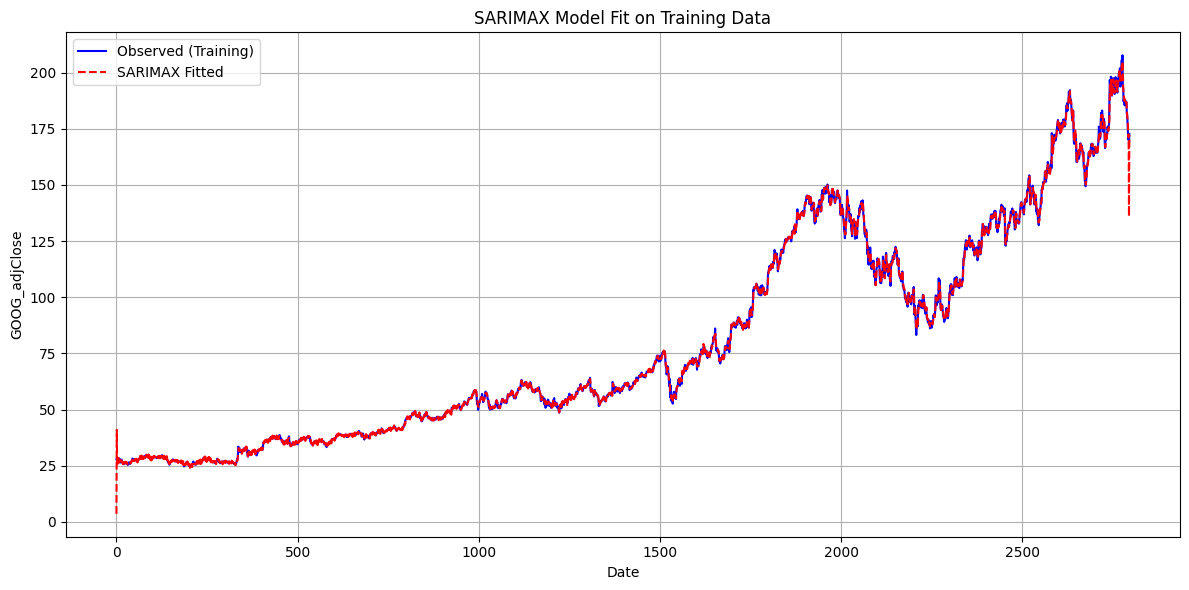

In [293]:
#training results 
fitted_values = sar_results.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(sar_y, label='Observed (Training)', color='blue')
plt.plot(fitted_values, label='SARIMAX Fitted', color='red', linestyle='--')
plt.title("SARIMAX Model Fit on Training Data")
plt.xlabel("Date")
plt.ylabel("GOOG_adjClose")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [294]:
# Create future exogenous input like LSTM (repeating last known values)
last_known = X_exog.iloc[-1]
sar_future_exog = pd.DataFrame(
    {col: [last_known[col]] * len(future_dates) for col in X_exog.columns},
    index=future_dates
)

# Forecast 15 future points
sar_forecast = sar_results.get_forecast(steps=len(future_dates), exog=sar_future_exog)
sar_forecast_mean = sar_forecast.predicted_mean


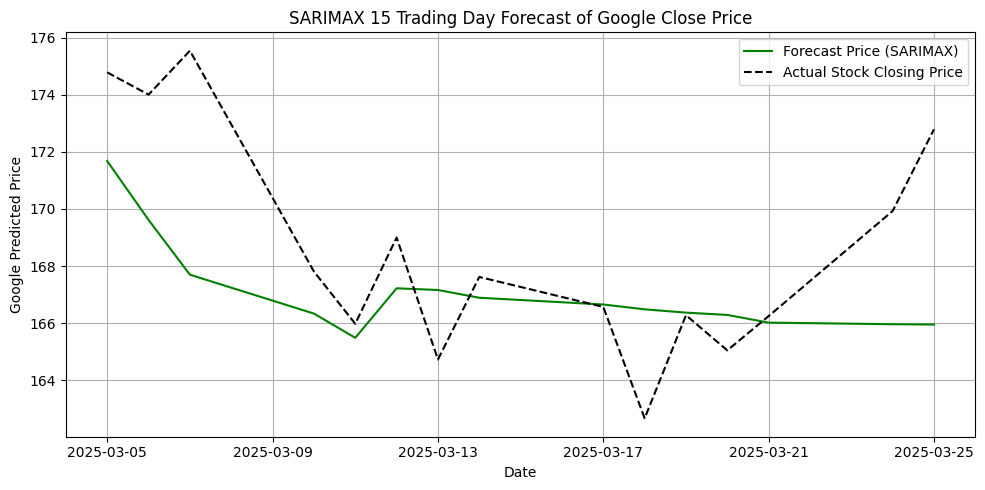

In [295]:
plt.figure(figsize=(10, 5))
plt.plot(future_dates, sar_forecast_mean, label='Forecast Price (SARIMAX)', color='green')
plt.plot(google_real['date'], google_real['GOOG_adjClose'], label='Actual Stock Closing Price', linestyle='--', color='black')
plt.title('SARIMAX 15 Trading Day Forecast of Google Close Price')
plt.xlabel('Date')
plt.ylabel('Google Predicted Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [296]:
#checking the pearson and spearman correlations 

sar_pearson_corr, _ = pearsonr(sar_forecast_mean, close_real)
sar_spearman_corr, _= spearmanr(sar_forecast_mean, close_real)
sar_mse = mean_squared_error(close_real, sar_forecast_mean)


print(f"SARIMAX Pearson Correlation: {sar_pearson_corr:.4f}")
print(f"SARIMAX Spearman Correlation: {sar_spearman_corr:.4f}")
print(f"SARIMAX MSE:                  {sar_mse:.4f}")

SARIMAX Pearson Correlation: 0.6264
SARIMAX Spearman Correlation: 0.4000
SARIMAX MSE:                  12.0690


In [ ]:
# # Convert predictions and dates to a DataFrame
# forecast_df = pd.DataFrame({
#     'date': future_dates,
#     'predicted_GOOG_close': bilstm_future_preds
# })

# # Save to CSV
# forecast_df.to_csv('GOOG_day_forecast.csv', index=False)

# print("✅ Forecast saved to 'bilstm_21_day_forecast.csv'")

✅ Forecast saved to 'bilstm_21_day_forecast.csv'
